<a href="https://colab.research.google.com/github/HegdeSiddesh/cs6910_assignment1/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from keras.datasets import fashion_mnist
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import random
np.random.seed(137) # To ensure that the random number generated are the same for every iteration
!pip install wandb -qq
import wandb
#from wandb.keras import WandbCallback

In [2]:
wandb.login()

wandb: Currently logged in as: hegdesiddesh (use `wandb login --relogin` to force relogin)


True

In [3]:
wandb.init(project="Assignment_1", name="Question 1")

##Question 1

Download the fashion-MNIST dataset and plot 1 sample image for each class.

In [4]:
#Load the fashion MNIST data 
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

In [5]:
#Get indices for the unique class labels
unique_indices = np.unique(y_train, return_index=True)

# Label reference : https://github.com/zalandoresearch/fashion-mnist
image_label = {0: "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat", 5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle boot"}

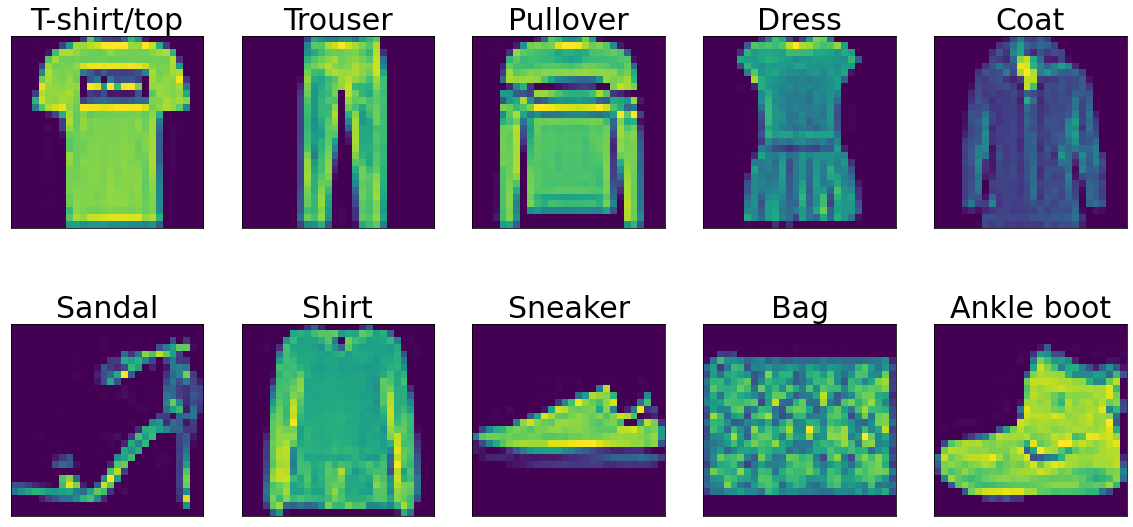

In [6]:
image_num=0
f, axarr = plt.subplots(2,5, sharex='col', sharey='row', figsize=(20,20))
plt.subplots_adjust(bottom=0.3, top=0.7, hspace=0)

# Plotting 2*5 subplot of images of different labels
for i in range(0,2):
  for j in range(0,5):
    axarr[i,j].imshow(x_train[unique_indices[1][image_num]])
    axarr[i,j].set_title(image_label[image_num], fontdict = {'fontsize' : 30})
    axarr[i,j].set_xticks([])
    axarr[i,j].set_yticks([])
    caption = image_label[image_num]
    wandb.log({"Samples": [wandb.Image(x_train[unique_indices[1][image_num]], caption=caption)]})
    image_num += 1

plt.show()

In [7]:
wandb.finish()

##Question 2

Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.



Your code should be flexible so that it is easy to change the number of hidden layers and the number of neurons in each hidden layer.





In [ ]:
class FeedForwardNeuralNetwork():
  def __init__(self, hidden_layer_sizes, epochs, learning_rate):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.learning_rate = learning_rate
    self.input_layer_size=0
    self.output_layer_size=1
    self.epochs = epochs
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}
    self.dw = {}
    self.db = {}
    self.dA = {}
    self.dH = {}
    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []

  def initialize_weights(self):
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    np.random.seed(137)
    for i in range(weight_counts):
      # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
      self.weights[i+1] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])
      # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
      # Creates a row of biases corresponding to each weight of the layer
      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))



  def softmax(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def sigmoid(self,X):
    #Utility to compute sigmoid function
    return 1.0/(1.0+np.exp(-X))

  def sigmoid_gradient(self,X):
    #Utility to compute sigmoid function
    #sigmoid = self.sigmoid(X)
    return X*(1-X)

  def cross_entropy(self,Y_true,Y_pred):
    #Utility to compute cross entropy loss
    # loss= -np.sum(np.sum(Y_true*np.log(Y_pred)))
    # return loss
    yl=np.multiply(Y_pred,Y_true)
    yl=yl[yl!=0]
    yl=-np.log(yl)
    yl=np.mean(yl)
    return yl

  def cross_entropy_gradient(self,Y_true,Y_pred):
    #Utility to compute gradient of cross entropy loss
    return -Y_true/(Y_pred)

  def tanh(self,X):
    # Utility to compute tanh function
    return np.tanh(X)

  def tanh_derivate(self,X):
    # Utility to compute tanh derivative
    return 1 - (np.tanh(X) ** 2)

  def relu(self,X):
    # Utility to compute relu function
    return X * (X > 0)

  def relu_derivative(self,X):
    # Utility to compute relu derivative
    X[X <= 0.0] = 0.0
    X[X > 0.0] = 1.0
    return X


  def forward_propogation(self, X):

    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)
    #print((self.H[0]).dtype)
    self.H[0] = self.H[0].astype('float128')


    #Compute a(x) = W_x*h(x-1) + b and h(a(x)) = sigmoid(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      self.H[i+1] = self.sigmoid(self.A[i+1])

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    self.H[len(self.hidden_layer_sizes)+1] = self.softmax(self.A[len(self.hidden_layer_sizes)+1]) 
    return

  def backward_propogation(self, X, Y,  dw_i, db_i):

    #Compute the gradient of loss wrt the activation of output layer
    #self.dH[len(self.hidden_layer_sizes)+1] = self.cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])
    self.dA[len(self.hidden_layer_sizes)+1] = -(Y - self.H[len(self.hidden_layer_sizes)+1])#cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])

    #Compute the partial derivatives for the weights and biases of the layers
    for i in range(len(self.hidden_layer_sizes), -1, -1):
      #eg:(assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
      dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
      #eg:(assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
      db_i[i+1] = self.dA[i+1]
      #eg:(assuming 2 hidden layers) dL/dH2 = dA3/dH2 * dL/dA3 = d(W3*H2 + B3)/dH2 * dL/dA3 = W3 * dL/dA3
      self.dH[i] = np.matmul(self.dA[i+1],self.weights[i+1].T)
      #eg:(assuming 2 hidden layers) dL/dA2 = dH2/dA2 * dL/dH2 = d(sigmoid(A2))/dA2 * dL/dH2 = sigmoid(A2) * (1-sigmoid(A2)) * dL/dH2 (for sigmoid activation)
      ## THIS IS HADAMARD PRODUCT IE NOT DOT PRODUCT
      self.dA[i] = np.multiply(self.sigmoid_gradient(self.H[i]), self.dH[i])    
    return


  def gradient_descent(self):
    for i in range(len(self.hidden_layer_sizes)+1):
        # w_t = w_{t-1} - eta*(dL/dw)
        self.weights[i+1] = self.weights[i+1] - self.learning_rate * self.dw[i+1]
        # b_t = b_{t-1} - eta*(dL/db)
        self.biases[i+1] = self.biases[i+1] - self.learning_rate * self.db[i+1]
    return 



  def fit(self, X, Y):
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    for e in range(self.epochs):
      #Gradients computed for this iteration/epoch
      y_preds = []

      for i in range(len(self.hidden_layer_sizes)+1):
        self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
        self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))

      for x, y in zip(X, Y):
        dw_i = {}
        db_i = {}

        #Forward Propogation
        self.forward_propogation(x)

        #loss and prediction class
        y_preds.append(self.H[len(self.hidden_layer_sizes)+1])
        
        #Backward Propogation using Loss funtion MSE
        self.backward_propogation(x,y, dw_i, db_i) 

        for i in range(len(self.hidden_layer_sizes)+1):
          self.dw[i+1] += dw_i[i+1]
          self.db[i+1] += db_i[i+1]

      #Update weights based on loss(GD hence once every epoch update)
      self.gradient_descent()
      y_preds = np.array(y_preds).squeeze()
      print("Epoch: ",e," Loss: ",self.cross_entropy(Y, y_preds) )


  def predict(self, X):
    #Find the predictions based on the fitted model
    values = self.forward_propogation(X)
    predictions = self.H[len(self.hidden_layer_sizes)+1]
    return predictions
      


In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(np.expand_dims(y_train,1)).toarray()

model = FeedForwardNeuralNetwork([100,256, 512], 10, 0.0001)

model.fit(x_train[0:10000], y_encoded[0:10000])

Epoch:  0  Loss:  11.158632878711602577
Epoch:  1  Loss:  56.459906650211561987
Epoch:  2  Loss:  103.18513388453057602
Epoch:  3  Loss:  145.23074438298768855
Epoch:  4  Loss:  178.47091976878302264
Epoch:  5  Loss:  203.24233294268224395
Epoch:  6  Loss:  190.9932346744848967
Epoch:  7  Loss:  194.9111013237063116
Epoch:  8  Loss:  202.96914933221613472
Epoch:  9  Loss:  242.3250418288858484


In [ ]:
#Check predictions for first 10 datapoints
for i in range(10):
  print(model.predict(x_train[i]))
  print(y_encoded[i])


[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[[4.76421650e-181 2.33680966e-048 6.93618127e-127 9.99987452e-001
  3.24047033e-121 4.81472199e-103 7.04679134e-200 1.33738844e-116
  1.25479764e-005 1.31170781e-156]]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


Issue might be in sending dw_i to the functions (check call by value or call by reference)

##Question 3

In [10]:
##Create classes for loss functions
#cross entropy loss

#Create classes for optimizers
#1.SGD
#2.NAG
#3.Momentum
#4.rmsprop
#7.adam
#6.nadam


In [8]:
def accuracy(y_true, y_pred):
  acc = np.sum(np.equal(y_true,y_pred))/y_true.shape[0]
  return acc

In [9]:
class FeedForwardNeuralNetwork():
  def __init__(self, hidden_layer_sizes, optimizer, loss_function, activation_function, output_activation, epochs = 1000, batch_size = 1024, initialization = "Random"):
    self.hidden_layer_sizes = hidden_layer_sizes
    self.optimizer = optimizer
    self.loss_function = loss_function
    self.activation_function = activation_function
    self.output_activation = output_activation
    self.input_layer_size=0
    self.output_layer_size=1
    self.epochs = epochs
    self.batch_size = batch_size
    self.initialization = initialization
    self.weights = {}
    self.biases = {}
    self.A = {}
    self.H = {}
    self.dw = {}
    self.db = {}
    self.dA = {}
    self.dH = {}
    #Layer sizes array will be initialzed after input and output layer size is obtained
    self.layer_sizes = []

  def initialize_weights(self):
    self.layer_sizes = [self.input_layer_size] + self.hidden_layer_sizes + [self.output_layer_size]
    weight_counts = len(self.hidden_layer_sizes)+1
    np.random.seed(137)
    self.optimizer.initialize(self.layer_sizes)
    for i in range(weight_counts):

      if self.initialization == "Random":
        # Setting up the weights per layer. Initialized randomly as matrix of size of previous layer * next layer 
        self.weights[i+1] = np.random.randn(self.layer_sizes[i], self.layer_sizes[i+1])
        # Setting up the biases per layer. Initialized to 0 as matrix of size of 1 * next layer 
        # Creates a row of biases corresponding to each weight of the layer

      if self.initialization == "Xavier-Normal":
        limit = np.sqrt(2 / float(self.layer_sizes[i] + self.layer_sizes[i+1]))
        self.weights[i+1] = np.random.normal(0.0, limit, size=(self.layer_sizes[i], self.layer_sizes[i+1]))

      if self.initialization == "Xavier-Uniform":
        limit = np.sqrt(6 / float(self.layer_sizes[i] + self.layer_sizes[i+1]))
        self.weights[i+1] = np.random.uniform(low=-limit, high=limit, size=(self.layer_sizes[i], self.layer_sizes[i+1]))

      self.biases[i+1] = np.zeros((1, self.layer_sizes[i+1]))


  def forward_propogation(self, X):

    self.A = {}
    self.H = {}
    #Initialize the output from input layer as H[0] into a single row(row vector)
    self.H[0] = X.reshape(1,-1)
    #print((self.H[0]).dtype)
    #self.H[0] = self.H[0].astype('float128')

    #Compute a(x) = W_x*h(x-1) and h(a(x)) = sigmoid(a(x)) for hidden layer
    for i in range(len(self.hidden_layer_sizes)):
      self.A[i+1] = np.matmul(self.H[i], self.weights[i+1]) + self.biases[i+1]
      self.H[i+1] = self.activation_function.compute_activation(self.A[i+1])

    #Compute a(x) and h(a(x)) = softmax(a(x)) for output layer
    self.A[len(self.hidden_layer_sizes)+1] = np.matmul(self.H[len(self.hidden_layer_sizes)], self.weights[len(self.hidden_layer_sizes)+1]) + self.biases[len(self.hidden_layer_sizes)+1]
    self.H[len(self.hidden_layer_sizes)+1] = self.output_activation.compute_activation(self.A[len(self.hidden_layer_sizes)+1]) 
    return

  def backward_propogation(self, X, Y,  dw_i, db_i):

    #Compute the gradient of loss wrt the activation of output layer
    #self.dH[len(self.hidden_layer_sizes)+1] = self.cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])
    self.dA[len(self.hidden_layer_sizes)+1] = -(Y - self.H[len(self.hidden_layer_sizes)+1])#cross_entropy_gradient(Y, self.H[len(self.hidden_layer_sizes)+1])

    #Compute the partial derivatives for the weights and biases of the layers
    for i in range(len(self.hidden_layer_sizes), -1, -1):
      #eg:(assuming 2 hidden layers) dL/dW3 = dA3/dW3 * dL/dA3 = d(W3*H2 + B3)/dW3 * dL/dA3 = H2 * dL/dA3
      dw_i[i+1] = np.matmul(self.H[i].T, self.dA[i+1])
      #eg:(assuming 2 hidden layers) dL/dB3 = dA3/dB3 * dL/dA3 = d(W3*H2 + B3)/dB3 * dL/dA3 = 1 * dL/dA3
      db_i[i+1] = self.dA[i+1]
      #eg:(assuming 2 hidden layers) dL/dH2 = dA3/dH2 * dL/dA3 = d(W3*H2 + B3)/dH2 * dL/dA3 = W3 * dL/dA3
      self.dH[i] = np.matmul(self.dA[i+1],self.weights[i+1].T)
      #eg:(assuming 2 hidden layers) dL/dA2 = dH2/dA2 * dL/dH2 = d(sigmoid(A2))/dA2 * dL/dH2 = sigmoid(A2) * (1-sigmoid(A2)) * dL/dH2 (for sigmoid activation)
      ## THIS IS HADAMARD PRODUCT IE NOT DOT PRODUCT
      self.dA[i] = np.multiply(self.activation_function.compute_derivative(self.H[i]), self.dH[i])    
    return


  def fit(self, X, Y, X_val, Y_val):
    self.input_layer_size = X.shape[1]*X.shape[1] # Number of features in data(features)
    self.output_layer_size = Y.shape[1] # Number of columns in output (label count)
    self.initialize_weights()
    for e in range(self.epochs):
      #Gradients computed for this iteration/epoch
      y_preds = []

      count = -1
      for i in range(len(self.hidden_layer_sizes)+1):
        self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
        self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))

      for x, y in zip(X, Y):
        dw_i = {}
        db_i = {}
        count += 1

        if count==self.batch_size:
          count = 0
          self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, self.hidden_layer_sizes)
          for i in range(len(self.hidden_layer_sizes)+1):
            self.dw[i+1] = np.zeros((self.layer_sizes[i], self.layer_sizes[i+1]))
            self.db[i+1] = np.zeros((1, self.layer_sizes[i+1]))


        #Forward Propogation
        self.forward_propogation(x)

        #loss and prediction class
        y_preds.append(self.H[len(self.hidden_layer_sizes)+1])
        
        #Backward Propogation using Loss funtion MSE
        self.backward_propogation(x,y, dw_i, db_i) 

        for i in range(len(self.hidden_layer_sizes)+1):
          self.dw[i+1] += dw_i[i+1]
          self.db[i+1] += db_i[i+1]

      #Update weights based on loss(GD hence once every epoch update)
      self.weights, self.biases = self.optimizer.update_parameters(self.weights, self.biases, self.dw, self.db, self.hidden_layer_sizes)
      #self.gradient_descent()
      y_preds = np.array(y_preds).squeeze()
      y_preds_validation = self.predict(X_val)
      print("Epoch: ",e," Training Loss: ",self.loss_function.compute_loss(Y, y_preds), " Validation Loss:", self.loss_function.compute_loss(Y_val, y_preds_validation)," Training Accuracy: ",accuracy(np.argmax(Y,1), np.argmax(y_preds,1)), " Validation Accuracy:", accuracy(np.argmax(Y_val,1), np.argmax(y_preds_validation,1)))
    
    return accuracy(np.argmax(Y,1), np.argmax(y_preds,1))

  def predict(self, X):
    #Find the predictions based on the fitted model
    y_pred = []
    for x in X:
      values = self.forward_propogation(x)
      predictions = self.H[len(self.hidden_layer_sizes)+1]
      y_pred.append(predictions)

    y_pred = np.array(y_pred).squeeze()
    return y_pred
      


In [24]:
class GD():
  def __init__(self, learning_rate = 0.001):
    self.learning_rate = learning_rate

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
  
  def initialize(self, all_layers):
    return

  def optimizer_name(self):
    return "gd"

  def update_parameters(self, weights, biases, dw, db, layers):
    for i in range(len(layers)+1):
        # w_t = w_{t-1} - eta*(dL/dw)
        weights[i+1] = weights[i+1] - self.learning_rate * dw[i+1]
        # b_t = b_{t-1} - eta*(dL/db)
        biases[i+1] = biases[i+1] - self.learning_rate * db[i+1]
    return weights, biases





class MomentumGD():
  def __init__(self, learning_rate = 0.001, gamma = 0.001):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.initialized = False
    self.update_history_w = {}
    self.update_history_b = {}
  
  def optimizer_name(self):
    return "momentum"
  
  def initialize(self, all_layers):
    self.update_history_w.clear()
    self.update_history_b.clear()
    for i in range(len(all_layers)-1):
      self.update_history_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.update_history_b[i+1] = np.zeros((1, all_layers[i+1]))
  
  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.update_history_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.update_history_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):

    for i in range(len(layers)+1):
        self.update_history_w[i+1] =self.gamma*self.update_history_w[i+1] + self.learning_rate*dw[i+1]
        weights[i+1] = weights[i+1] - self.update_history_w[i+1]

        self.update_history_b[i+1] =self.gamma*self.update_history_b[i+1] + self.learning_rate*db[i+1]
        biases[i+1] = biases[i+1] - self.update_history_b[i+1]
        
    return weights, biases


class RMSProp():
  def __init__(self, learning_rate = 0.001, gamma = 0.001, epsilon = 1e-8, v_w = 0.001, v_b = 0.001):
    self.learning_rate = learning_rate
    self.gamma = gamma
    self.epsilon = epsilon
    self.v_w = {}
    self.v_b = {}
    self.initialized = False

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
  
  def optimizer_name(self):
    return "rmsprop"
  
  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.gamma = parameters["gamma"]
    self.epsilon = parameters["epsilon"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    # self.v_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    # self.v_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):
    #if self.initialized == False:
      #self.initialized = True
      #print(weights[1].shape[0])
      #print(weights[len(weights)].shape[-1])
      #all_layers = [weights[1].shape[0]] + layers + [weights[len(weights)].shape[-1]]
      #for i in range(len(layers)+1):
      #  self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      #  self.v_b[i+1] = np.zeros((1, all_layers[i+1]))

    for i in range(len(layers)+1):
        self.v_w[i+1] =self.gamma*self.v_w[i+1] + (1-self.gamma)* ((dw[i+1])**2)
        self.v_b[i+1] =self.gamma*self.v_b[i+1] + (1-self.gamma)* ((db[i+1])**2)

        weights[i+1] = weights[i+1] - ((self.learning_rate)/np.sqrt(self.v_w[i+1] + self.epsilon))*dw[i+1]
        biases[i+1] = biases[i+1] - ((self.learning_rate)/np.sqrt(self.v_b[i+1] + self.epsilon))*db[i+1]
        
    return weights, biases


class Nadam():
  #Reference : http://cs229.stanford.edu/proj2015/054_report.pdf
  #Formula reference: https://towardsdatascience.com/10-gradient-descent-optimisation-algorithms-86989510b5e9
  def __init__(self, learning_rate = 0.001, gamma = 0.001, epsilon = 1e-8):
    self.learning_rate = learning_rate
    self.beta1 = 0.9
    self.beta2 = 0.999
    self.epsilon = epsilon
    self.initialized = False
    self.v_w = {}
    self.v_b = {}
    self.m_w = {}
    self.m_b = {}
    self.iterations = 1;

  def initialize(self, all_layers):
    self.v_w.clear()
    self.v_b.clear()
    self.m_w.clear()
    self.m_b.clear()
    for i in range(len(all_layers)-1):
      self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
      self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
      self.m_b[i+1] = np.zeros((1, all_layers[i+1]))

  def set_learning_rate(self, learning_rate):
    self.learning_rate = learning_rate
  
  def optimizer_name(self):
    return "nadam"

  def set_initial_parameters(self, parameters):
    self.learning_rate = parameters["learning_rate"]
    self.beta1 = parameters["beta1"]
    self.beta2 = parameters["beta2"]
    self.epsilon = parameters["epsilon"]
    #layer_sizes = parameters["layer_sizes"]
    #for i in range(len(layer_sizes)-1):#Since we count for hidden layers and not output/input layer
    #  self.v_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.v_b[i+1] = np.zeros((1, layer_sizes[i+1]))
    #  self.m_w[i+1] = np.zeros((layer_sizes[i], layer_sizes[i+1]))
    #  self.m_b[i+1] = np.zeros((1, layer_sizes[i+1]))


  def update_parameters(self, weights, biases, dw, db, layers):

    #if self.initialized == False:
    #  self.initialized = True
    #  all_layers = [weights[1].shape[0]] + layers + [weights[len(weights)].shape[-1]]
    #  for i in range(len(layers)+1):
    #    self.v_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.v_b[i+1] = np.zeros((1, all_layers[i+1]))
    #    self.m_w[i+1] = np.zeros((all_layers[i], all_layers[i+1]))
    #    self.m_b[i+1] = np.zeros((1, all_layers[i+1]))


    for i in range(len(layers)+1):

        self.m_w[i+1] = self.beta1*self.m_w[i+1] + (1-self.beta1)* (dw[i+1])
        self.m_b[i+1] = self.beta1*self.m_b[i+1] + (1-self.beta1)* (db[i+1])

        self.v_w[i+1] = self.beta2*self.v_w[i+1] + (1-self.beta2)* ((dw[i+1])**2)
        self.v_b[i+1] = self.beta2*self.v_b[i+1] + (1-self.beta2)* ((db[i+1])**2)

        m_w_hat = self.m_w[i+1]/(1-(self.beta1**self.iterations))
        m_b_hat = self.m_b[i+1]/(1-(self.beta1**self.iterations))
			  
        v_w_hat = self.v_w[i+1]/(1-(self.beta2**self.iterations))
        v_b_hat = self.v_b[i+1]/(1-(self.beta2**self.iterations))

        weights[i+1] = weights[i+1] - ((self.learning_rate)/(np.sqrt(v_w_hat) + self.epsilon))*(self.beta1 * m_w_hat + ((1-self.beta1)/(1-(self.beta1**self.iterations))*dw[i+1]))
        biases[i+1] = biases[i+1] - ((self.learning_rate)/(np.sqrt(v_b_hat) + self.epsilon))*(self.beta1 * m_b_hat + ((1-self.beta1)/(1-(self.beta1**self.iterations))*db[i+1]))

    self.iterations += 1
        
    return weights, biases


In [11]:
class Sigmoid():
  def compute_activation(self, X):
    return 1.0/(1.0+np.exp(-X))

  def compute_derivative(self, X):
    #Here X is the activation value
    #sigmoid = compute_activation(X)
    return X*(1-X)

class Softmax():
  def compute_activation(self, X):
    #Utility to compute softmax function
    exponentials = np.exp(X)
    return exponentials / np.sum(exponentials)

  def compute_derivative(self, X):
    #Here X is the activation value
    #softmax = self.compute_activation(X)
    return X*(1-X)

In [12]:
class CrossEntropy():
  def compute_loss(self, Y_true, Y_pred):
    loss=np.multiply(Y_pred,Y_true)
    loss=loss[loss!=0]
    loss=-np.log(loss)
    loss=np.mean(loss)
    return loss

  def compute_derivative(self, Y_pred,Y_true):
    return -Y_true/(Y_pred)

In [25]:
from sklearn.preprocessing import OneHotEncoder

#One hot encoding of the class labels
encoder = OneHotEncoder()
y_encoded = encoder.fit_transform(np.expand_dims(y_train,1)).toarray()


#Add layer sizes for the hidden layers
layers = [64,32,64]


#all_layers = [x_train.shape[1]*x_train.shape[1]] + layers + [y_encoded.shape[1]]


optimizers = {"gradient_descent":GD(), "momentum_gd":MomentumGD(), "rmsprop":RMSProp(), "nadam":Nadam()}
loss_functions = {"cross_entropy":CrossEntropy()}
activation_functions = {"sigmoid": Sigmoid(), "softmax":Softmax()}


#Select optimizer(sgd)
optimizer_sgd = optimizers["gradient_descent"]
optimizer_parameters_sgd = {"learning_rate":0.0001}
optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)

#Select optimizer(momentum)
optimizer_momentum = optimizers["momentum_gd"]
optimizer_parameters_momentum = {"learning_rate":0.0001, "gamma":0.002}
optimizer_momentum.set_initial_parameters(optimizer_parameters_momentum)


#Select optimizer(rmsprop)
optimizer_rmsprop = optimizers["rmsprop"]
optimizer_parameters_rmsprop = {"learning_rate":0.0005, "gamma":0.001, "epsilon":1e-8}
optimizer_rmsprop.set_initial_parameters(optimizer_parameters_rmsprop)


#Select optimizer(nadam)
optimizer_nadam = optimizers["nadam"]
optimizer_parameters_nadam = {"learning_rate":0.0001, "beta1":0.09, "beta2":0.999, "epsilon":1e-8}
optimizer_nadam.set_initial_parameters(optimizer_parameters_nadam)


#Select loss function
loss_cross_entropy = loss_functions["cross_entropy"]


#Select activation(hidden layers)
activation_sigmoid = activation_functions["sigmoid"]


#Select activation(output layer)
output_activation_softmax = activation_functions["softmax"]


model = FeedForwardNeuralNetwork(layers, optimizer_rmsprop, loss_cross_entropy, activation_sigmoid, output_activation_softmax, 10, 512, initialization = "Xavier-Normal")
model.fit(x_train[0:10000], y_encoded[0:10000], x_train[0:10000], y_encoded[0:10000])


Epoch:  0  Training Loss:  2.30990057767627  Validation Loss: 2.241753789109762  Training Accuracy:  0.1742  Validation Accuracy: 0.3161


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:  1  Training Loss:  2.207366038115591  Validation Loss: 2.1741649086435726  Training Accuracy:  0.3851  Validation Accuracy: 0.5085
Epoch:  2  Training Loss:  2.1469009514168618  Validation Loss: 2.113415677875807  Training Accuracy:  0.4868  Validation Accuracy: 0.5504
Epoch:  3  Training Loss:  2.0814121395181857  Validation Loss: 2.04463281833734  Training Accuracy:  0.5364  Validation Accuracy: 0.5651
Epoch:  4  Training Loss:  2.009304201406888  Validation Loss: 1.9678001544367711  Training Accuracy:  0.5504  Validation Accuracy: 0.5758
Epoch:  5  Training Loss:  1.9296753731802645  Validation Loss: 1.885000532997372  Training Accuracy:  0.5629  Validation Accuracy: 0.5739
Epoch:  6  Training Loss:  1.8441138119805047  Validation Loss: 1.7962677819840982  Training Accuracy:  0.5695  Validation Accuracy: 0.5839
Epoch:  7  Training Loss:  1.7558449163184742  Validation Loss: 1.7071086000859894  Training Accuracy:  0.5785  Validation Accuracy: 0.5848
Epoch:  8  Training Loss: 

0.588

In [14]:
#Check predictions for first 10 datapoints
#for i in range(10):
print(model.predict(x_train[:10]))
print(y_encoded[:10])


[[0.07758506 0.0948295  0.10498906 0.11103547 0.09455865 0.09971193
  0.08399989 0.10611724 0.09627533 0.13089787]
 [0.10747866 0.11446313 0.09449066 0.10769083 0.10225434 0.08745298
  0.08710151 0.10715986 0.09934876 0.09255926]
 [0.10042389 0.14354829 0.08976164 0.11345678 0.09894896 0.08700502
  0.08674125 0.10148452 0.09097723 0.08765242]
 [0.10319756 0.1326482  0.09331807 0.11353397 0.10058204 0.08401851
  0.08622643 0.10742226 0.09582372 0.08322925]
 [0.09452448 0.14137233 0.08911561 0.11576831 0.0951662  0.08598917
  0.08507013 0.10613812 0.09842622 0.08842944]
 [0.08538717 0.0966466  0.1248587  0.10571301 0.11007079 0.08107628
  0.08814404 0.10183002 0.10268688 0.10358651]
 [0.087599   0.09694702 0.09799622 0.11382373 0.08518421 0.10520137
  0.078249   0.128387   0.09732745 0.10928499]
 [0.0828545  0.0932304  0.12466592 0.10440929 0.10952943 0.08652464
  0.08702022 0.10170473 0.10123591 0.10882496]
 [0.07944527 0.1101644  0.10071617 0.11032244 0.09617662 0.10019923
  0.08894188


Ref : https://pyimagesearch.com/2021/05/06/understanding-weight-initialization-for-neural-networks/

For Sigmoid/Tanh --> Use Xavier

Xavier Normal: For the normal distribution the limit value is constructed by averaging the Fin and Fout together and then taking the square-root (Jones, 2016). A zero-center (µ = 0) is then used:

Xavier Uniform: 

For Relu ---> Use He

Weight_decay --> beta2 in adam/nadam

##Question 4 : Wandb plots and hyperparameter tuning

In [26]:
sweep_config = {
    #GridSearch over the hyperparameters
    'method': 'grid',
    'metric': {
      'name': 'accuracy',
      'goal': 'maximize'   
    },
    'parameters': {
        'epochs': {
            'values': [5,10]
        },
        'learning_rate': {
            'values': [0.01, 0.001, 0.0001]
        },
        'optimizer': {
            'values': ['sgd', 'momentum', 'rmsprop', 'nadam']
        },
        'activation': {
            'values': ['sigmoid']
        },
        'output_activation': {
            'values': ['softmax']
        },
        'hidden_layers': {
            'values': [ [32,64],[32,64,128],[32,64,128,256]]
        },
        'batch_size':{
            'values':[16,32,64]
        }
    }
}

In [27]:
sweep_id = wandb.sweep(sweep_config, project="Assignment_1")

Create sweep with ID: kiiqyemv
Sweep URL: https://wandb.ai/hegdesiddesh/Assignment_1/sweeps/kiiqyemv


In [28]:
def train():

    config_defaults = {
        'epochs': 2,
        'learning_rate': 0.0001,
        'hidden_layers':[50,75],
        'optimizer':'nadam',
        'activation':'sigmoid',
        'output_activation': 'softmax',
        'batch_size':100
    }

    # Initialize a new wandb run
    wandb.init(project='Assignment_1',config=config_defaults)
    
    
    # Config is a variable that holds and saves hyperparameters and inputs
    config = wandb.config
    learning_rate = config.learning_rate
    epochs = config.epochs
    hidden_layers = config.hidden_layers

    if config.activation=="sigmoid":
      activation = activation_sigmoid
    #activation = config.activation

    if config.output_activation=="softmax":
      output_activation = output_activation_softmax
    #output_activation = config.output_activation

    if config.optimizer=="sgd":
      #Select optimizer(sgd)
      optimizer_sgd = optimizers["gradient_descent"]
      optimizer_parameters_sgd = {"learning_rate":config.learning_rate}
      optimizer_sgd.set_initial_parameters(optimizer_parameters_sgd)
      optimizer = optimizer_sgd
    if config.optimizer=="momentum":
      #Select optimizer(momentum)
      optimizer_momentum = optimizers["momentum_gd"]
      optimizer_parameters_momentum = {"learning_rate":config.learning_rate, "gamma":0.002}
      optimizer_momentum.set_initial_parameters(optimizer_parameters_momentum)
      optimizer = optimizer_momentum
    if config.optimizer=="rmsprop":
      #Select optimizer(rmsprop)
      optimizer_rmsprop = optimizers["rmsprop"]
      optimizer_parameters_rmsprop = {"learning_rate":config.learning_rate, "gamma":0.001, "epsilon":1e-8}
      optimizer_rmsprop.set_initial_parameters(optimizer_parameters_rmsprop)
      optimizer = optimizer_rmsprop
    if config.optimizer=="nadam":
      #Select optimizer(nadam)
      optimizer_nadam = optimizers["nadam"]
      optimizer_parameters_nadam = {"learning_rate":config.learning_rate, "beta1":0.09, "beta2":0.999, "epsilon":1e-8}
      optimizer_nadam.set_initial_parameters(optimizer_parameters_nadam)
      optimizer = optimizer_nadam
    #optimizer = config.optimizer
    batch_size = config.batch_size
    # Model training here
    model    = FeedForwardNeuralNetwork(hidden_layers, optimizer, loss_cross_entropy, activation, output_activation, epochs, batch_size, initialization = "Xavier-Normal")
    accuracy = model.fit(x_train[0:10000], y_encoded[0:10000], x_train[0:10000], y_encoded[0:10000])

#train_network(network, dataset, config.learning_rate, config.epochs, n_outputs)

# 3. Log metrics over time to visualize performance
    wandb.log({"accuracy": accuracy})

In [ ]:
wandb.agent(sweep_id, train)

wandb: Agent Starting Run: w9r3pe16 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


Epoch:  0  Training Loss:  2.302155143435857  Validation Loss: 2.213997497909828  Training Accuracy:  0.2239  Validation Accuracy: 0.3272
Epoch:  1  Training Loss:  2.183487644421643  Validation Loss: 2.1556362781827567  Training Accuracy:  0.3745  Validation Accuracy: 0.4302
Epoch:  2  Training Loss:  2.132693953551704  Validation Loss: 2.1050047645550376  Training Accuracy:  0.4348  Validation Accuracy: 0.4792
Epoch:  3  Training Loss:  2.07960755885803  Validation Loss: 2.0518064684279946  Training Accuracy:  0.4721  Validation Accuracy: 0.4911
Epoch:  4  Training Loss:  2.0263979922757587  Validation Loss: 1.9963794834284467  Training Accuracy:  0.4896  Validation Accuracy: 0.5325


accuracy,▁
accuracy,0.4896


wandb: Agent Starting Run: p09gest9 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3011679490252903  Validation Loss: 2.2200050724013245  Training Accuracy:  0.223  Validation Accuracy: 0.3225
Epoch:  1  Training Loss:  2.186410766579539  Validation Loss: 2.1554816421201473  Training Accuracy:  0.3774  Validation Accuracy: 0.4385
Epoch:  2  Training Loss:  2.1320204018429942  Validation Loss: 2.1049190617457345  Training Accuracy:  0.439  Validation Accuracy: 0.4938
Epoch:  3  Training Loss:  2.0797517872729774  Validation Loss: 2.0528380056943334  Training Accuracy:  0.487  Validation Accuracy: 0.5184
Epoch:  4  Training Loss:  2.0261242619831044  Validation Loss: 1.9966571260726167  Training Accuracy:  0.5101  Validation Accuracy: 0.5308


accuracy,▁
accuracy,0.5101


wandb: Agent Starting Run: v08q04z8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8205725895469953  Validation Loss: 1.3845585452370501  Training Accuracy:  0.4537  Validation Accuracy: 0.6088
Epoch:  1  Training Loss:  1.156904077469187  Validation Loss: 0.9719300667496452  Training Accuracy:  0.6374  Validation Accuracy: 0.6697
Epoch:  2  Training Loss:  0.8917252630690602  Validation Loss: 0.8152123775966875  Training Accuracy:  0.682  Validation Accuracy: 0.6944
Epoch:  3  Training Loss:  0.7888681384793  Validation Loss: 0.748300219413983  Training Accuracy:  0.7117  Validation Accuracy: 0.7213
Epoch:  4  Training Loss:  0.7413044727223838  Validation Loss: 0.7193374790534445  Training Accuracy:  0.722  Validation Accuracy: 0.7359


accuracy,▁
accuracy,0.722


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ns5vkt1o with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.191993532997601  Validation Loss: 2.0250279540639964  Training Accuracy:  0.3177  Validation Accuracy: 0.4951
Epoch:  1  Training Loss:  1.8836760676623845  Validation Loss: 1.741147073942631  Training Accuracy:  0.53  Validation Accuracy: 0.5892
Epoch:  2  Training Loss:  1.625746531345784  Validation Loss: 1.5224414966353677  Training Accuracy:  0.5788  Validation Accuracy: 0.6323
Epoch:  3  Training Loss:  1.433389884360487  Validation Loss: 1.3592377044040769  Training Accuracy:  0.6126  Validation Accuracy: 0.6415
Epoch:  4  Training Loss:  1.2901227015132093  Validation Loss: 1.224174110777331  Training Accuracy:  0.6386  Validation Accuracy: 0.6482


accuracy,▁
accuracy,0.6386


wandb: Agent Starting Run: cybeqkb2 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.302155143435857  Validation Loss: 2.213997497909828  Training Accuracy:  0.2239  Validation Accuracy: 0.3272
Epoch:  1  Training Loss:  2.183487644421643  Validation Loss: 2.1556362781827567  Training Accuracy:  0.3745  Validation Accuracy: 0.4302
Epoch:  2  Training Loss:  2.132693953551704  Validation Loss: 2.1050047645550376  Training Accuracy:  0.4348  Validation Accuracy: 0.4792
Epoch:  3  Training Loss:  2.07960755885803  Validation Loss: 2.0518064684279946  Training Accuracy:  0.4721  Validation Accuracy: 0.4911
Epoch:  4  Training Loss:  2.0263979922757587  Validation Loss: 1.9963794834284467  Training Accuracy:  0.4896  Validation Accuracy: 0.5325


accuracy,▁
accuracy,0.4896


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: u5u0cgqc with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3011679490252903  Validation Loss: 2.2200050724013245  Training Accuracy:  0.223  Validation Accuracy: 0.3225
Epoch:  1  Training Loss:  2.186410766579539  Validation Loss: 2.1554816421201473  Training Accuracy:  0.3774  Validation Accuracy: 0.4385
Epoch:  2  Training Loss:  2.1320204018429942  Validation Loss: 2.1049190617457345  Training Accuracy:  0.439  Validation Accuracy: 0.4938
Epoch:  3  Training Loss:  2.0797517872729774  Validation Loss: 2.0528380056943334  Training Accuracy:  0.487  Validation Accuracy: 0.5184
Epoch:  4  Training Loss:  2.0261242619831044  Validation Loss: 1.9966571260726167  Training Accuracy:  0.5101  Validation Accuracy: 0.5308


accuracy,▁
accuracy,0.5101


wandb: Agent Starting Run: jk7vp98d with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8205725895469953  Validation Loss: 1.3845585452370501  Training Accuracy:  0.4537  Validation Accuracy: 0.6088
Epoch:  1  Training Loss:  1.156904077469187  Validation Loss: 0.9719300667496452  Training Accuracy:  0.6374  Validation Accuracy: 0.6697
Epoch:  2  Training Loss:  0.8917252630690602  Validation Loss: 0.8152123775966875  Training Accuracy:  0.682  Validation Accuracy: 0.6944
Epoch:  3  Training Loss:  0.7888681384793  Validation Loss: 0.748300219413983  Training Accuracy:  0.7117  Validation Accuracy: 0.7213
Epoch:  4  Training Loss:  0.7413044727223838  Validation Loss: 0.7193374790534445  Training Accuracy:  0.722  Validation Accuracy: 0.7359


accuracy,▁
accuracy,0.722


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zsav4ul8 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9438147152405225  Validation Loss: 1.7154682584929284  Training Accuracy:  0.4609  Validation Accuracy: 0.5864
Epoch:  1  Training Loss:  1.5852190238006536  Validation Loss: 1.473571488476001  Training Accuracy:  0.5638  Validation Accuracy: 0.6093
Epoch:  2  Training Loss:  1.3899775572904336  Validation Loss: 1.3113880737812929  Training Accuracy:  0.6095  Validation Accuracy: 0.6481
Epoch:  3  Training Loss:  1.2592228672184766  Validation Loss: 1.205720620121183  Training Accuracy:  0.6301  Validation Accuracy: 0.6348
Epoch:  4  Training Loss:  1.161845144485138  Validation Loss: 1.1141518875305916  Training Accuracy:  0.6388  Validation Accuracy: 0.6464


accuracy,▁
accuracy,0.6388


wandb: Agent Starting Run: voxm1lp3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.302155143435857  Validation Loss: 2.213997497909828  Training Accuracy:  0.2239  Validation Accuracy: 0.3272
Epoch:  1  Training Loss:  2.183487644421643  Validation Loss: 2.1556362781827567  Training Accuracy:  0.3745  Validation Accuracy: 0.4302
Epoch:  2  Training Loss:  2.132693953551704  Validation Loss: 2.1050047645550376  Training Accuracy:  0.4348  Validation Accuracy: 0.4792
Epoch:  3  Training Loss:  2.07960755885803  Validation Loss: 2.0518064684279946  Training Accuracy:  0.4721  Validation Accuracy: 0.4911
Epoch:  4  Training Loss:  2.0263979922757587  Validation Loss: 1.9963794834284467  Training Accuracy:  0.4896  Validation Accuracy: 0.5325


accuracy,▁
accuracy,0.4896


wandb: Agent Starting Run: naeicxvs with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3011679490252903  Validation Loss: 2.2200050724013245  Training Accuracy:  0.223  Validation Accuracy: 0.3225
Epoch:  1  Training Loss:  2.186410766579539  Validation Loss: 2.1554816421201473  Training Accuracy:  0.3774  Validation Accuracy: 0.4385
Epoch:  2  Training Loss:  2.1320204018429942  Validation Loss: 2.1049190617457345  Training Accuracy:  0.439  Validation Accuracy: 0.4938
Epoch:  3  Training Loss:  2.0797517872729774  Validation Loss: 2.0528380056943334  Training Accuracy:  0.487  Validation Accuracy: 0.5184
Epoch:  4  Training Loss:  2.0261242619831044  Validation Loss: 1.9966571260726167  Training Accuracy:  0.5101  Validation Accuracy: 0.5308


accuracy,▁
accuracy,0.5101


wandb: Agent Starting Run: 55o7kh0j with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8205725895469953  Validation Loss: 1.3845585452370501  Training Accuracy:  0.4537  Validation Accuracy: 0.6088
Epoch:  1  Training Loss:  1.156904077469187  Validation Loss: 0.9719300667496452  Training Accuracy:  0.6374  Validation Accuracy: 0.6697
Epoch:  2  Training Loss:  0.8917252630690602  Validation Loss: 0.8152123775966875  Training Accuracy:  0.682  Validation Accuracy: 0.6944
Epoch:  3  Training Loss:  0.7888681384793  Validation Loss: 0.748300219413983  Training Accuracy:  0.7117  Validation Accuracy: 0.7213
Epoch:  4  Training Loss:  0.7413044727223838  Validation Loss: 0.7193374790534445  Training Accuracy:  0.722  Validation Accuracy: 0.7359


accuracy,▁
accuracy,0.722


wandb: Agent Starting Run: 3wqj5yii with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9531694964990485  Validation Loss: 1.7421455923049252  Training Accuracy:  0.4338  Validation Accuracy: 0.5522
Epoch:  1  Training Loss:  1.6255821228648704  Validation Loss: 1.5238930111199638  Training Accuracy:  0.5521  Validation Accuracy: 0.5916
Epoch:  2  Training Loss:  1.4481727251702896  Validation Loss: 1.3795527415882156  Training Accuracy:  0.5862  Validation Accuracy: 0.6086
Epoch:  3  Training Loss:  1.3220621385260878  Validation Loss: 1.2649922618218543  Training Accuracy:  0.6039  Validation Accuracy: 0.6237
Epoch:  4  Training Loss:  1.2111292246917795  Validation Loss: 1.1576240633595265  Training Accuracy:  0.6256  Validation Accuracy: 0.6548


accuracy,▁
accuracy,0.6256


wandb: Agent Starting Run: hodppqk6 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317186043992361  Validation Loss: 2.290983129519806  Training Accuracy:  0.1047  Validation Accuracy: 0.1185
Epoch:  1  Training Loss:  2.287788766686445  Validation Loss: 2.2827641433153163  Training Accuracy:  0.1756  Validation Accuracy: 0.1686
Epoch:  2  Training Loss:  2.2803250478681987  Validation Loss: 2.2761095478053934  Training Accuracy:  0.2177  Validation Accuracy: 0.2005
Epoch:  3  Training Loss:  2.2734433402961427  Validation Loss: 2.268415835040917  Training Accuracy:  0.2477  Validation Accuracy: 0.2248
Epoch:  4  Training Loss:  2.265392693928858  Validation Loss: 2.2602784068077946  Training Accuracy:  0.2711  Validation Accuracy: 0.2355


accuracy,▁
accuracy,0.2711


wandb: Agent Starting Run: zm7jt6u7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317141314126536  Validation Loss: 2.290959734703017  Training Accuracy:  0.105  Validation Accuracy: 0.1186
Epoch:  1  Training Loss:  2.287682514532667  Validation Loss: 2.2823879410498065  Training Accuracy:  0.1744  Validation Accuracy: 0.1679
Epoch:  2  Training Loss:  2.2801254287859805  Validation Loss: 2.275923678344101  Training Accuracy:  0.2192  Validation Accuracy: 0.2033
Epoch:  3  Training Loss:  2.273146654692962  Validation Loss: 2.2682823844800373  Training Accuracy:  0.2486  Validation Accuracy: 0.2258
Epoch:  4  Training Loss:  2.26523804389652  Validation Loss: 2.260154044111779  Training Accuracy:  0.2699  Validation Accuracy: 0.2383


accuracy,▁
accuracy,0.2699


wandb: Agent Starting Run: 7xvv7wu4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8898003200652744  Validation Loss: 1.462906303644035  Training Accuracy:  0.311  Validation Accuracy: 0.4
Epoch:  1  Training Loss:  1.2347373525269918  Validation Loss: 1.0599702889541343  Training Accuracy:  0.5161  Validation Accuracy: 0.622
Epoch:  2  Training Loss:  0.966298666687024  Validation Loss: 0.8814699725534747  Training Accuracy:  0.6581  Validation Accuracy: 0.6969
Epoch:  3  Training Loss:  0.8371047996026771  Validation Loss: 0.7849955466727001  Training Accuracy:  0.6923  Validation Accuracy: 0.7116
Epoch:  4  Training Loss:  0.7747168105880875  Validation Loss: 0.7495323909158963  Training Accuracy:  0.7093  Validation Accuracy: 0.7206


accuracy,▁
accuracy,0.7093


wandb: Agent Starting Run: t33gev4m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9898572156182246  Validation Loss: 1.7267968058742107  Training Accuracy:  0.2964  Validation Accuracy: 0.3803
Epoch:  1  Training Loss:  1.6157616578624605  Validation Loss: 1.5207826096068362  Training Accuracy:  0.4116  Validation Accuracy: 0.4471
Epoch:  2  Training Loss:  1.4408381673690227  Validation Loss: 1.3649003182329458  Training Accuracy:  0.4295  Validation Accuracy: 0.4464
Epoch:  3  Training Loss:  1.3105772386428172  Validation Loss: 1.2556834093736688  Training Accuracy:  0.4739  Validation Accuracy: 0.5181
Epoch:  4  Training Loss:  1.2190883013292122  Validation Loss: 1.1851967642510266  Training Accuracy:  0.5401  Validation Accuracy: 0.5522


accuracy,▁
accuracy,0.5401


wandb: Agent Starting Run: 0v18bnyk with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317186043992361  Validation Loss: 2.290983129519806  Training Accuracy:  0.1047  Validation Accuracy: 0.1185
Epoch:  1  Training Loss:  2.287788766686445  Validation Loss: 2.2827641433153163  Training Accuracy:  0.1756  Validation Accuracy: 0.1686
Epoch:  2  Training Loss:  2.2803250478681987  Validation Loss: 2.2761095478053934  Training Accuracy:  0.2177  Validation Accuracy: 0.2005
Epoch:  3  Training Loss:  2.2734433402961427  Validation Loss: 2.268415835040917  Training Accuracy:  0.2477  Validation Accuracy: 0.2248
Epoch:  4  Training Loss:  2.265392693928858  Validation Loss: 2.2602784068077946  Training Accuracy:  0.2711  Validation Accuracy: 0.2355


accuracy,▁
accuracy,0.2711


wandb: Agent Starting Run: 84lg3f3p with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317141314126536  Validation Loss: 2.290959734703017  Training Accuracy:  0.105  Validation Accuracy: 0.1186
Epoch:  1  Training Loss:  2.287682514532667  Validation Loss: 2.2823879410498065  Training Accuracy:  0.1744  Validation Accuracy: 0.1679
Epoch:  2  Training Loss:  2.2801254287859805  Validation Loss: 2.275923678344101  Training Accuracy:  0.2192  Validation Accuracy: 0.2033
Epoch:  3  Training Loss:  2.273146654692962  Validation Loss: 2.2682823844800373  Training Accuracy:  0.2486  Validation Accuracy: 0.2258
Epoch:  4  Training Loss:  2.26523804389652  Validation Loss: 2.260154044111779  Training Accuracy:  0.2699  Validation Accuracy: 0.2383


accuracy,▁
accuracy,0.2699


wandb: Agent Starting Run: pvqa3h1x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8898003200652744  Validation Loss: 1.462906303644035  Training Accuracy:  0.311  Validation Accuracy: 0.4
Epoch:  1  Training Loss:  1.2347373525269918  Validation Loss: 1.0599702889541343  Training Accuracy:  0.5161  Validation Accuracy: 0.622
Epoch:  2  Training Loss:  0.966298666687024  Validation Loss: 0.8814699725534747  Training Accuracy:  0.6581  Validation Accuracy: 0.6969
Epoch:  3  Training Loss:  0.8371047996026771  Validation Loss: 0.7849955466727001  Training Accuracy:  0.6923  Validation Accuracy: 0.7116
Epoch:  4  Training Loss:  0.7747168105880875  Validation Loss: 0.7495323909158963  Training Accuracy:  0.7093  Validation Accuracy: 0.7206


accuracy,▁
accuracy,0.7093


wandb: Agent Starting Run: dq26v3nm with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9814187653773239  Validation Loss: 1.7264703158076802  Training Accuracy:  0.3118  Validation Accuracy: 0.3531
Epoch:  1  Training Loss:  1.616069367388577  Validation Loss: 1.529071519618662  Training Accuracy:  0.4107  Validation Accuracy: 0.4833
Epoch:  2  Training Loss:  1.4548139326049891  Validation Loss: 1.3785549243301713  Training Accuracy:  0.4312  Validation Accuracy: 0.52
Epoch:  3  Training Loss:  1.3197127157937754  Validation Loss: 1.2657702805456261  Training Accuracy:  0.4693  Validation Accuracy: 0.5142
Epoch:  4  Training Loss:  1.2289011661871239  Validation Loss: 1.1874685739400528  Training Accuracy:  0.5076  Validation Accuracy: 0.5589


accuracy,▁
accuracy,0.5076


wandb: Agent Starting Run: xwrwm5p5 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317186043992361  Validation Loss: 2.290983129519806  Training Accuracy:  0.1047  Validation Accuracy: 0.1185
Epoch:  1  Training Loss:  2.287788766686445  Validation Loss: 2.2827641433153163  Training Accuracy:  0.1756  Validation Accuracy: 0.1686
Epoch:  2  Training Loss:  2.2803250478681987  Validation Loss: 2.2761095478053934  Training Accuracy:  0.2177  Validation Accuracy: 0.2005
Epoch:  3  Training Loss:  2.2734433402961427  Validation Loss: 2.268415835040917  Training Accuracy:  0.2477  Validation Accuracy: 0.2248
Epoch:  4  Training Loss:  2.265392693928858  Validation Loss: 2.2602784068077946  Training Accuracy:  0.2711  Validation Accuracy: 0.2355


accuracy,▁
accuracy,0.2711


wandb: Agent Starting Run: j3yscpi0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317141314126536  Validation Loss: 2.290959734703017  Training Accuracy:  0.105  Validation Accuracy: 0.1186
Epoch:  1  Training Loss:  2.287682514532667  Validation Loss: 2.2823879410498065  Training Accuracy:  0.1744  Validation Accuracy: 0.1679
Epoch:  2  Training Loss:  2.2801254287859805  Validation Loss: 2.275923678344101  Training Accuracy:  0.2192  Validation Accuracy: 0.2033
Epoch:  3  Training Loss:  2.273146654692962  Validation Loss: 2.2682823844800373  Training Accuracy:  0.2486  Validation Accuracy: 0.2258
Epoch:  4  Training Loss:  2.26523804389652  Validation Loss: 2.260154044111779  Training Accuracy:  0.2699  Validation Accuracy: 0.2383


accuracy,▁
accuracy,0.2699


wandb: Agent Starting Run: yjc21tmb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8898003200652744  Validation Loss: 1.462906303644035  Training Accuracy:  0.311  Validation Accuracy: 0.4
Epoch:  1  Training Loss:  1.2347373525269918  Validation Loss: 1.0599702889541343  Training Accuracy:  0.5161  Validation Accuracy: 0.622
Epoch:  2  Training Loss:  0.966298666687024  Validation Loss: 0.8814699725534747  Training Accuracy:  0.6581  Validation Accuracy: 0.6969
Epoch:  3  Training Loss:  0.8371047996026771  Validation Loss: 0.7849955466727001  Training Accuracy:  0.6923  Validation Accuracy: 0.7116
Epoch:  4  Training Loss:  0.7747168105880875  Validation Loss: 0.7495323909158963  Training Accuracy:  0.7093  Validation Accuracy: 0.7206


accuracy,▁
accuracy,0.7093


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: bvf3gwck with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9898300767007528  Validation Loss: 1.7282261512771677  Training Accuracy:  0.3042  Validation Accuracy: 0.4022
Epoch:  1  Training Loss:  1.6102759847627206  Validation Loss: 1.508046156418441  Training Accuracy:  0.4482  Validation Accuracy: 0.5611
Epoch:  2  Training Loss:  1.4236211419242086  Validation Loss: 1.3419415035684052  Training Accuracy:  0.4979  Validation Accuracy: 0.5601
Epoch:  3  Training Loss:  1.276335962575765  Validation Loss: 1.213759035377321  Training Accuracy:  0.5596  Validation Accuracy: 0.6157
Epoch:  4  Training Loss:  1.1685025185523326  Validation Loss: 1.122266198745469  Training Accuracy:  0.5932  Validation Accuracy: 0.6463


accuracy,▁
accuracy,0.5932


wandb: Agent Starting Run: qnmflm30 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318141392696834  Validation Loss: 2.303076449743257  Training Accuracy:  0.1037  Validation Accuracy: 0.1285
Epoch:  1  Training Loss:  2.303945355081175  Validation Loss: 2.3024352389877136  Training Accuracy:  0.1062  Validation Accuracy: 0.1342
Epoch:  2  Training Loss:  2.303370199920778  Validation Loss: 2.3018913969658836  Training Accuracy:  0.108  Validation Accuracy: 0.1359
Epoch:  3  Training Loss:  2.3028261603389018  Validation Loss: 2.301387160872566  Training Accuracy:  0.1106  Validation Accuracy: 0.1348
Epoch:  4  Training Loss:  2.3023713350172237  Validation Loss: 2.3009577150642877  Training Accuracy:  0.1117  Validation Accuracy: 0.135


accuracy,▁
accuracy,0.1117


wandb: Agent Starting Run: ga66j1kt with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181169883955155  Validation Loss: 2.3030732295755003  Training Accuracy:  0.1037  Validation Accuracy: 0.1279
Epoch:  1  Training Loss:  2.3039370983090612  Validation Loss: 2.3024348265804737  Training Accuracy:  0.1064  Validation Accuracy: 0.1333
Epoch:  2  Training Loss:  2.3033700704585676  Validation Loss: 2.301889444118051  Training Accuracy:  0.1079  Validation Accuracy: 0.135
Epoch:  3  Training Loss:  2.302825510461112  Validation Loss: 2.3013859855916023  Training Accuracy:  0.1105  Validation Accuracy: 0.1335
Epoch:  4  Training Loss:  2.302370870704616  Validation Loss: 2.300954751380675  Training Accuracy:  0.1118  Validation Accuracy: 0.1348


accuracy,▁
accuracy,0.1118


wandb: Agent Starting Run: sngue1wp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9497357354150835  Validation Loss: 1.5254343867253546  Training Accuracy:  0.2129  Validation Accuracy: 0.2857
Epoch:  1  Training Loss:  1.3103586723497136  Validation Loss: 1.1926691106009188  Training Accuracy:  0.4226  Validation Accuracy: 0.419
Epoch:  2  Training Loss:  1.120418732796349  Validation Loss: 1.0963623946431793  Training Accuracy:  0.5149  Validation Accuracy: 0.5022
Epoch:  3  Training Loss:  1.0388174774624472  Validation Loss: 1.0131806395946816  Training Accuracy:  0.5624  Validation Accuracy: 0.5242
Epoch:  4  Training Loss:  1.006460697852294  Validation Loss: 0.9983675879846196  Training Accuracy:  0.5797  Validation Accuracy: 0.5806


accuracy,▁
accuracy,0.5797


wandb: Agent Starting Run: uwu28w9t with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9955073185152847  Validation Loss: 1.7059348861440302  Training Accuracy:  0.1915  Validation Accuracy: 0.2189
Epoch:  1  Training Loss:  1.6168417607211123  Validation Loss: 1.5155565915399871  Training Accuracy:  0.33  Validation Accuracy: 0.3463
Epoch:  2  Training Loss:  1.4332795879364557  Validation Loss: 1.3706207613374837  Training Accuracy:  0.3853  Validation Accuracy: 0.3594
Epoch:  3  Training Loss:  1.323421074454023  Validation Loss: 1.287335513208265  Training Accuracy:  0.4112  Validation Accuracy: 0.377
Epoch:  4  Training Loss:  1.2548621576161532  Validation Loss: 1.2321385464991643  Training Accuracy:  0.4284  Validation Accuracy: 0.4426


accuracy,▁
accuracy,0.4284


wandb: Agent Starting Run: km3j8bns with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318141392696834  Validation Loss: 2.303076449743257  Training Accuracy:  0.1037  Validation Accuracy: 0.1285
Epoch:  1  Training Loss:  2.303945355081175  Validation Loss: 2.3024352389877136  Training Accuracy:  0.1062  Validation Accuracy: 0.1342
Epoch:  2  Training Loss:  2.303370199920778  Validation Loss: 2.3018913969658836  Training Accuracy:  0.108  Validation Accuracy: 0.1359
Epoch:  3  Training Loss:  2.3028261603389018  Validation Loss: 2.301387160872566  Training Accuracy:  0.1106  Validation Accuracy: 0.1348
Epoch:  4  Training Loss:  2.3023713350172237  Validation Loss: 2.3009577150642877  Training Accuracy:  0.1117  Validation Accuracy: 0.135


accuracy,▁
accuracy,0.1117


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: zaln54iu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181169883955155  Validation Loss: 2.3030732295755003  Training Accuracy:  0.1037  Validation Accuracy: 0.1279
Epoch:  1  Training Loss:  2.3039370983090612  Validation Loss: 2.3024348265804737  Training Accuracy:  0.1064  Validation Accuracy: 0.1333
Epoch:  2  Training Loss:  2.3033700704585676  Validation Loss: 2.301889444118051  Training Accuracy:  0.1079  Validation Accuracy: 0.135
Epoch:  3  Training Loss:  2.302825510461112  Validation Loss: 2.3013859855916023  Training Accuracy:  0.1105  Validation Accuracy: 0.1335
Epoch:  4  Training Loss:  2.302370870704616  Validation Loss: 2.300954751380675  Training Accuracy:  0.1118  Validation Accuracy: 0.1348


accuracy,▁
accuracy,0.1118


wandb: Agent Starting Run: hzemrkca with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9497357354150835  Validation Loss: 1.5254343867253546  Training Accuracy:  0.2129  Validation Accuracy: 0.2857
Epoch:  1  Training Loss:  1.3103586723497136  Validation Loss: 1.1926691106009188  Training Accuracy:  0.4226  Validation Accuracy: 0.419
Epoch:  2  Training Loss:  1.120418732796349  Validation Loss: 1.0963623946431793  Training Accuracy:  0.5149  Validation Accuracy: 0.5022
Epoch:  3  Training Loss:  1.0388174774624472  Validation Loss: 1.0131806395946816  Training Accuracy:  0.5624  Validation Accuracy: 0.5242
Epoch:  4  Training Loss:  1.006460697852294  Validation Loss: 0.9983675879846196  Training Accuracy:  0.5797  Validation Accuracy: 0.5806


accuracy,▁
accuracy,0.5797


wandb: Agent Starting Run: u1dxwemu with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9926354817464191  Validation Loss: 1.703132363466236  Training Accuracy:  0.1935  Validation Accuracy: 0.2157
Epoch:  1  Training Loss:  1.6054475734641684  Validation Loss: 1.4941212350740802  Training Accuracy:  0.3397  Validation Accuracy: 0.3675
Epoch:  2  Training Loss:  1.4241451276478967  Validation Loss: 1.3662907837597253  Training Accuracy:  0.3899  Validation Accuracy: 0.3561
Epoch:  3  Training Loss:  1.3181845648187416  Validation Loss: 1.2871828149219524  Training Accuracy:  0.4195  Validation Accuracy: 0.378
Epoch:  4  Training Loss:  1.2534996430175576  Validation Loss: 1.2254212097477362  Training Accuracy:  0.4531  Validation Accuracy: 0.4329


accuracy,▁
accuracy,0.4531


wandb: Agent Starting Run: p7lz4sma with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.318141392696834  Validation Loss: 2.303076449743257  Training Accuracy:  0.1037  Validation Accuracy: 0.1285
Epoch:  1  Training Loss:  2.303945355081175  Validation Loss: 2.3024352389877136  Training Accuracy:  0.1062  Validation Accuracy: 0.1342
Epoch:  2  Training Loss:  2.303370199920778  Validation Loss: 2.3018913969658836  Training Accuracy:  0.108  Validation Accuracy: 0.1359
Epoch:  3  Training Loss:  2.3028261603389018  Validation Loss: 2.301387160872566  Training Accuracy:  0.1106  Validation Accuracy: 0.1348
Epoch:  4  Training Loss:  2.3023713350172237  Validation Loss: 2.3009577150642877  Training Accuracy:  0.1117  Validation Accuracy: 0.135


accuracy,▁
accuracy,0.1117


wandb: Agent Starting Run: 23x9v22z with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3181169883955155  Validation Loss: 2.3030732295755003  Training Accuracy:  0.1037  Validation Accuracy: 0.1279
Epoch:  1  Training Loss:  2.3039370983090612  Validation Loss: 2.3024348265804737  Training Accuracy:  0.1064  Validation Accuracy: 0.1333
Epoch:  2  Training Loss:  2.3033700704585676  Validation Loss: 2.301889444118051  Training Accuracy:  0.1079  Validation Accuracy: 0.135
Epoch:  3  Training Loss:  2.302825510461112  Validation Loss: 2.3013859855916023  Training Accuracy:  0.1105  Validation Accuracy: 0.1335
Epoch:  4  Training Loss:  2.302370870704616  Validation Loss: 2.300954751380675  Training Accuracy:  0.1118  Validation Accuracy: 0.1348


accuracy,▁
accuracy,0.1118


wandb: Agent Starting Run: u1nwnsdx with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9497357354150835  Validation Loss: 1.5254343867253546  Training Accuracy:  0.2129  Validation Accuracy: 0.2857
Epoch:  1  Training Loss:  1.3103586723497136  Validation Loss: 1.1926691106009188  Training Accuracy:  0.4226  Validation Accuracy: 0.419
Epoch:  2  Training Loss:  1.120418732796349  Validation Loss: 1.0963623946431793  Training Accuracy:  0.5149  Validation Accuracy: 0.5022
Epoch:  3  Training Loss:  1.0388174774624472  Validation Loss: 1.0131806395946816  Training Accuracy:  0.5624  Validation Accuracy: 0.5242
Epoch:  4  Training Loss:  1.006460697852294  Validation Loss: 0.9983675879846196  Training Accuracy:  0.5797  Validation Accuracy: 0.5806


accuracy,▁
accuracy,0.5797


wandb: Agent Starting Run: k1wl2koy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 5
wandb: 	hidden_layers: [32, 64, 128, 256]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.0013281778240097  Validation Loss: 1.7077227216589115  Training Accuracy:  0.1899  Validation Accuracy: 0.2106
Epoch:  1  Training Loss:  1.6375661187544155  Validation Loss: 1.563482779658967  Training Accuracy:  0.2935  Validation Accuracy: 0.3253
Epoch:  2  Training Loss:  1.4793928008788098  Validation Loss: 1.406417392269575  Training Accuracy:  0.3788  Validation Accuracy: 0.3766
Epoch:  3  Training Loss:  1.3567381105999345  Validation Loss: 1.3116327026452261  Training Accuracy:  0.3884  Validation Accuracy: 0.3783
Epoch:  4  Training Loss:  1.2770767389832314  Validation Loss: 1.242998340999263  Training Accuracy:  0.4236  Validation Accuracy: 0.3894


accuracy,▁
accuracy,0.4236


wandb: Agent Starting Run: 4g5iubsl with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.302155143435857  Validation Loss: 2.213997497909828  Training Accuracy:  0.2239  Validation Accuracy: 0.3272
Epoch:  1  Training Loss:  2.183487644421643  Validation Loss: 2.1556362781827567  Training Accuracy:  0.3745  Validation Accuracy: 0.4302
Epoch:  2  Training Loss:  2.132693953551704  Validation Loss: 2.1050047645550376  Training Accuracy:  0.4348  Validation Accuracy: 0.4792
Epoch:  3  Training Loss:  2.07960755885803  Validation Loss: 2.0518064684279946  Training Accuracy:  0.4721  Validation Accuracy: 0.4911
Epoch:  4  Training Loss:  2.0263979922757587  Validation Loss: 1.9963794834284467  Training Accuracy:  0.4896  Validation Accuracy: 0.5325
Epoch:  5  Training Loss:  1.96935942408372  Validation Loss: 1.9377525427790119  Training Accuracy:  0.5202  Validation Accuracy: 0.5553
Epoch:  6  Training Loss:  1.9080979630126935  Validation Loss: 1.8756647847725012  Training Accuracy:  0.5426  Validation Accuracy: 0.5842
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.5935


wandb: Agent Starting Run: kzvqd39x with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3011679490252903  Validation Loss: 2.2200050724013245  Training Accuracy:  0.223  Validation Accuracy: 0.3225
Epoch:  1  Training Loss:  2.186410766579539  Validation Loss: 2.1554816421201473  Training Accuracy:  0.3774  Validation Accuracy: 0.4385
Epoch:  2  Training Loss:  2.1320204018429942  Validation Loss: 2.1049190617457345  Training Accuracy:  0.439  Validation Accuracy: 0.4938
Epoch:  3  Training Loss:  2.0797517872729774  Validation Loss: 2.0528380056943334  Training Accuracy:  0.487  Validation Accuracy: 0.5184
Epoch:  4  Training Loss:  2.0261242619831044  Validation Loss: 1.9966571260726167  Training Accuracy:  0.5101  Validation Accuracy: 0.5308
Epoch:  5  Training Loss:  1.9685649493946993  Validation Loss: 1.9376122639564546  Training Accuracy:  0.5286  Validation Accuracy: 0.5693
Epoch:  6  Training Loss:  1.9095734014318801  Validation Loss: 1.8784613659168972  Training Accuracy:  0.5472  Validation Accuracy: 0.5805
Epoch:  7  Training Loss

accuracy,▁
accuracy,0.5987


wandb: Agent Starting Run: ks1s1hvb with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8205725895469953  Validation Loss: 1.3845585452370501  Training Accuracy:  0.4537  Validation Accuracy: 0.6088
Epoch:  1  Training Loss:  1.156904077469187  Validation Loss: 0.9719300667496452  Training Accuracy:  0.6374  Validation Accuracy: 0.6697
Epoch:  2  Training Loss:  0.8917252630690602  Validation Loss: 0.8152123775966875  Training Accuracy:  0.682  Validation Accuracy: 0.6944
Epoch:  3  Training Loss:  0.7888681384793  Validation Loss: 0.748300219413983  Training Accuracy:  0.7117  Validation Accuracy: 0.7213
Epoch:  4  Training Loss:  0.7413044727223838  Validation Loss: 0.7193374790534445  Training Accuracy:  0.722  Validation Accuracy: 0.7359
Epoch:  5  Training Loss:  0.7227559542958505  Validation Loss: 0.6966888229078503  Training Accuracy:  0.7333  Validation Accuracy: 0.7415
Epoch:  6  Training Loss:  0.7084798035344902  Validation Loss: 0.7106388764729099  Training Accuracy:  0.7452  Validation Accuracy: 0.7464
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.7647


wandb: Agent Starting Run: d3zqabv1 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9746581898316988  Validation Loss: 1.7665918903354727  Training Accuracy:  0.3989  Validation Accuracy: 0.5129
Epoch:  1  Training Loss:  1.6394367535016052  Validation Loss: 1.52423095669607  Training Accuracy:  0.5181  Validation Accuracy: 0.5947
Epoch:  2  Training Loss:  1.4423678635990906  Validation Loss: 1.3690318783452189  Training Accuracy:  0.5894  Validation Accuracy: 0.6072
Epoch:  3  Training Loss:  1.3073198271787878  Validation Loss: 1.257317957721882  Training Accuracy:  0.609  Validation Accuracy: 0.6296
Epoch:  4  Training Loss:  1.2042320391670434  Validation Loss: 1.1517805496212425  Training Accuracy:  0.6169  Validation Accuracy: 0.631
Epoch:  5  Training Loss:  1.1137264494477734  Validation Loss: 1.0689387502922858  Training Accuracy:  0.6403  Validation Accuracy: 0.6504
Epoch:  6  Training Loss:  1.0390502028031376  Validation Loss: 1.0064602725955465  Training Accuracy:  0.6472  Validation Accuracy: 0.6536
Epoch:  7  Training Loss:

accuracy,▁
accuracy,0.6721


wandb: Agent Starting Run: 6yfhacir with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.302155143435857  Validation Loss: 2.213997497909828  Training Accuracy:  0.2239  Validation Accuracy: 0.3272
Epoch:  1  Training Loss:  2.183487644421643  Validation Loss: 2.1556362781827567  Training Accuracy:  0.3745  Validation Accuracy: 0.4302
Epoch:  2  Training Loss:  2.132693953551704  Validation Loss: 2.1050047645550376  Training Accuracy:  0.4348  Validation Accuracy: 0.4792
Epoch:  3  Training Loss:  2.07960755885803  Validation Loss: 2.0518064684279946  Training Accuracy:  0.4721  Validation Accuracy: 0.4911
Epoch:  4  Training Loss:  2.0263979922757587  Validation Loss: 1.9963794834284467  Training Accuracy:  0.4896  Validation Accuracy: 0.5325
Epoch:  5  Training Loss:  1.96935942408372  Validation Loss: 1.9377525427790119  Training Accuracy:  0.5202  Validation Accuracy: 0.5553
Epoch:  6  Training Loss:  1.9080979630126935  Validation Loss: 1.8756647847725012  Training Accuracy:  0.5426  Validation Accuracy: 0.5842
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.5935


wandb: Agent Starting Run: lll8bd16 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3011679490252903  Validation Loss: 2.2200050724013245  Training Accuracy:  0.223  Validation Accuracy: 0.3225
Epoch:  1  Training Loss:  2.186410766579539  Validation Loss: 2.1554816421201473  Training Accuracy:  0.3774  Validation Accuracy: 0.4385
Epoch:  2  Training Loss:  2.1320204018429942  Validation Loss: 2.1049190617457345  Training Accuracy:  0.439  Validation Accuracy: 0.4938
Epoch:  3  Training Loss:  2.0797517872729774  Validation Loss: 2.0528380056943334  Training Accuracy:  0.487  Validation Accuracy: 0.5184
Epoch:  4  Training Loss:  2.0261242619831044  Validation Loss: 1.9966571260726167  Training Accuracy:  0.5101  Validation Accuracy: 0.5308
Epoch:  5  Training Loss:  1.9685649493946993  Validation Loss: 1.9376122639564546  Training Accuracy:  0.5286  Validation Accuracy: 0.5693
Epoch:  6  Training Loss:  1.9095734014318801  Validation Loss: 1.8784613659168972  Training Accuracy:  0.5472  Validation Accuracy: 0.5805
Epoch:  7  Training Loss

accuracy,▁
accuracy,0.5987


wandb: Agent Starting Run: xnh7289u with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8205725895469953  Validation Loss: 1.3845585452370501  Training Accuracy:  0.4537  Validation Accuracy: 0.6088
Epoch:  1  Training Loss:  1.156904077469187  Validation Loss: 0.9719300667496452  Training Accuracy:  0.6374  Validation Accuracy: 0.6697
Epoch:  2  Training Loss:  0.8917252630690602  Validation Loss: 0.8152123775966875  Training Accuracy:  0.682  Validation Accuracy: 0.6944
Epoch:  3  Training Loss:  0.7888681384793  Validation Loss: 0.748300219413983  Training Accuracy:  0.7117  Validation Accuracy: 0.7213
Epoch:  4  Training Loss:  0.7413044727223838  Validation Loss: 0.7193374790534445  Training Accuracy:  0.722  Validation Accuracy: 0.7359
Epoch:  5  Training Loss:  0.7227559542958505  Validation Loss: 0.6966888229078503  Training Accuracy:  0.7333  Validation Accuracy: 0.7415
Epoch:  6  Training Loss:  0.7084798035344902  Validation Loss: 0.7106388764729099  Training Accuracy:  0.7452  Validation Accuracy: 0.7464
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.7647


wandb: Agent Starting Run: wfog3lqo with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.984063696403113  Validation Loss: 1.7830796251460852  Training Accuracy:  0.4248  Validation Accuracy: 0.5895
Epoch:  1  Training Loss:  1.6546065474004954  Validation Loss: 1.5383259678235675  Training Accuracy:  0.5368  Validation Accuracy: 0.6046
Epoch:  2  Training Loss:  1.4552140855191662  Validation Loss: 1.3684048859813776  Training Accuracy:  0.6013  Validation Accuracy: 0.6214
Epoch:  3  Training Loss:  1.310435123235516  Validation Loss: 1.2536415726995154  Training Accuracy:  0.6172  Validation Accuracy: 0.6299
Epoch:  4  Training Loss:  1.1990447276453566  Validation Loss: 1.1549135789316063  Training Accuracy:  0.6324  Validation Accuracy: 0.6436
Epoch:  5  Training Loss:  1.1104621055480066  Validation Loss: 1.071986297743742  Training Accuracy:  0.6466  Validation Accuracy: 0.6561
Epoch:  6  Training Loss:  1.0427121381992424  Validation Loss: 1.0046579327329201  Training Accuracy:  0.6617  Validation Accuracy: 0.6805
Epoch:  7  Training Los

accuracy,▁
accuracy,0.7033


wandb: Agent Starting Run: f4i8juny with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.302155143435857  Validation Loss: 2.213997497909828  Training Accuracy:  0.2239  Validation Accuracy: 0.3272
Epoch:  1  Training Loss:  2.183487644421643  Validation Loss: 2.1556362781827567  Training Accuracy:  0.3745  Validation Accuracy: 0.4302
Epoch:  2  Training Loss:  2.132693953551704  Validation Loss: 2.1050047645550376  Training Accuracy:  0.4348  Validation Accuracy: 0.4792
Epoch:  3  Training Loss:  2.07960755885803  Validation Loss: 2.0518064684279946  Training Accuracy:  0.4721  Validation Accuracy: 0.4911
Epoch:  4  Training Loss:  2.0263979922757587  Validation Loss: 1.9963794834284467  Training Accuracy:  0.4896  Validation Accuracy: 0.5325
Epoch:  5  Training Loss:  1.96935942408372  Validation Loss: 1.9377525427790119  Training Accuracy:  0.5202  Validation Accuracy: 0.5553
Epoch:  6  Training Loss:  1.9080979630126935  Validation Loss: 1.8756647847725012  Training Accuracy:  0.5426  Validation Accuracy: 0.5842
Epoch:  7  Training Loss:  1

accuracy,▁
accuracy,0.5935


wandb: Agent Starting Run: 6jlyuzed with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.3011679490252903  Validation Loss: 2.2200050724013245  Training Accuracy:  0.223  Validation Accuracy: 0.3225
Epoch:  1  Training Loss:  2.186410766579539  Validation Loss: 2.1554816421201473  Training Accuracy:  0.3774  Validation Accuracy: 0.4385
Epoch:  2  Training Loss:  2.1320204018429942  Validation Loss: 2.1049190617457345  Training Accuracy:  0.439  Validation Accuracy: 0.4938
Epoch:  3  Training Loss:  2.0797517872729774  Validation Loss: 2.0528380056943334  Training Accuracy:  0.487  Validation Accuracy: 0.5184
Epoch:  4  Training Loss:  2.0261242619831044  Validation Loss: 1.9966571260726167  Training Accuracy:  0.5101  Validation Accuracy: 0.5308
Epoch:  5  Training Loss:  1.9685649493946993  Validation Loss: 1.9376122639564546  Training Accuracy:  0.5286  Validation Accuracy: 0.5693
Epoch:  6  Training Loss:  1.9095734014318801  Validation Loss: 1.8784613659168972  Training Accuracy:  0.5472  Validation Accuracy: 0.5805
Epoch:  7  Training Loss

accuracy,▁
accuracy,0.5987


wandb: Agent Starting Run: 84a9cn4v with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8205725895469953  Validation Loss: 1.3845585452370501  Training Accuracy:  0.4537  Validation Accuracy: 0.6088
Epoch:  1  Training Loss:  1.156904077469187  Validation Loss: 0.9719300667496452  Training Accuracy:  0.6374  Validation Accuracy: 0.6697
Epoch:  2  Training Loss:  0.8917252630690602  Validation Loss: 0.8152123775966875  Training Accuracy:  0.682  Validation Accuracy: 0.6944
Epoch:  3  Training Loss:  0.7888681384793  Validation Loss: 0.748300219413983  Training Accuracy:  0.7117  Validation Accuracy: 0.7213
Epoch:  4  Training Loss:  0.7413044727223838  Validation Loss: 0.7193374790534445  Training Accuracy:  0.722  Validation Accuracy: 0.7359
Epoch:  5  Training Loss:  0.7227559542958505  Validation Loss: 0.6966888229078503  Training Accuracy:  0.7333  Validation Accuracy: 0.7415
Epoch:  6  Training Loss:  0.7084798035344902  Validation Loss: 0.7106388764729099  Training Accuracy:  0.7452  Validation Accuracy: 0.7464
Epoch:  7  Training Loss:  

accuracy,▁
accuracy,0.7647


wandb: Agent Starting Run: bwkcnyv0 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64]
wandb: 	learning_rate: 0.0001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9658119895629744  Validation Loss: 1.7568383792175326  Training Accuracy:  0.4251  Validation Accuracy: 0.5658
Epoch:  1  Training Loss:  1.6403411722309778  Validation Loss: 1.5436816425403104  Training Accuracy:  0.5417  Validation Accuracy: 0.6052
Epoch:  2  Training Loss:  1.4606485737404589  Validation Loss: 1.3872866490106195  Training Accuracy:  0.5736  Validation Accuracy: 0.6066
Epoch:  3  Training Loss:  1.3242099978744886  Validation Loss: 1.2674728780913715  Training Accuracy:  0.6032  Validation Accuracy: 0.6171
Epoch:  4  Training Loss:  1.2246536463302238  Validation Loss: 1.1789789763534568  Training Accuracy:  0.6161  Validation Accuracy: 0.635
Epoch:  5  Training Loss:  1.1419621220944651  Validation Loss: 1.0951696237208615  Training Accuracy:  0.6201  Validation Accuracy: 0.6312
Epoch:  6  Training Loss:  1.063208793429116  Validation Loss: 1.0398908490056664  Training Accuracy:  0.6349  Validation Accuracy: 0.6374
Epoch:  7  Training Lo

accuracy,▁
accuracy,0.6776


wandb: Agent Starting Run: 37tpwrbp with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317186043992361  Validation Loss: 2.290983129519806  Training Accuracy:  0.1047  Validation Accuracy: 0.1185
Epoch:  1  Training Loss:  2.287788766686445  Validation Loss: 2.2827641433153163  Training Accuracy:  0.1756  Validation Accuracy: 0.1686
Epoch:  2  Training Loss:  2.2803250478681987  Validation Loss: 2.2761095478053934  Training Accuracy:  0.2177  Validation Accuracy: 0.2005
Epoch:  3  Training Loss:  2.2734433402961427  Validation Loss: 2.268415835040917  Training Accuracy:  0.2477  Validation Accuracy: 0.2248
Epoch:  4  Training Loss:  2.265392693928858  Validation Loss: 2.2602784068077946  Training Accuracy:  0.2711  Validation Accuracy: 0.2355
Epoch:  5  Training Loss:  2.2572234880580773  Validation Loss: 2.2520638681744045  Training Accuracy:  0.2846  Validation Accuracy: 0.2447
Epoch:  6  Training Loss:  2.248730151776578  Validation Loss: 2.243165703676739  Training Accuracy:  0.3  Validation Accuracy: 0.2536
Epoch:  7  Training Loss:  2.2

accuracy,▁
accuracy,0.3463


wandb: Agent Starting Run: y0jhzh0b with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317141314126536  Validation Loss: 2.290959734703017  Training Accuracy:  0.105  Validation Accuracy: 0.1186
Epoch:  1  Training Loss:  2.287682514532667  Validation Loss: 2.2823879410498065  Training Accuracy:  0.1744  Validation Accuracy: 0.1679
Epoch:  2  Training Loss:  2.2801254287859805  Validation Loss: 2.275923678344101  Training Accuracy:  0.2192  Validation Accuracy: 0.2033
Epoch:  3  Training Loss:  2.273146654692962  Validation Loss: 2.2682823844800373  Training Accuracy:  0.2486  Validation Accuracy: 0.2258
Epoch:  4  Training Loss:  2.26523804389652  Validation Loss: 2.260154044111779  Training Accuracy:  0.2699  Validation Accuracy: 0.2383
Epoch:  5  Training Loss:  2.257009992957443  Validation Loss: 2.251626701674166  Training Accuracy:  0.282  Validation Accuracy: 0.2432
Epoch:  6  Training Loss:  2.24823667484881  Validation Loss: 2.2426727183276656  Training Accuracy:  0.2979  Validation Accuracy: 0.2533
Epoch:  7  Training Loss:  2.23878

accuracy,▁
accuracy,0.3426


wandb: Agent Starting Run: 1jcq2fp4 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8898003200652744  Validation Loss: 1.462906303644035  Training Accuracy:  0.311  Validation Accuracy: 0.4
Epoch:  1  Training Loss:  1.2347373525269918  Validation Loss: 1.0599702889541343  Training Accuracy:  0.5161  Validation Accuracy: 0.622
Epoch:  2  Training Loss:  0.966298666687024  Validation Loss: 0.8814699725534747  Training Accuracy:  0.6581  Validation Accuracy: 0.6969
Epoch:  3  Training Loss:  0.8371047996026771  Validation Loss: 0.7849955466727001  Training Accuracy:  0.6923  Validation Accuracy: 0.7116
Epoch:  4  Training Loss:  0.7747168105880875  Validation Loss: 0.7495323909158963  Training Accuracy:  0.7093  Validation Accuracy: 0.7206
Epoch:  5  Training Loss:  0.750458222585209  Validation Loss: 0.7429819392678262  Training Accuracy:  0.7232  Validation Accuracy: 0.7265
Epoch:  6  Training Loss:  0.7425257766488278  Validation Loss: 0.7368968614375584  Training Accuracy:  0.7318  Validation Accuracy: 0.7342
Epoch:  7  Training Loss:  0

accuracy,▁
accuracy,0.7529


wandb: Agent Starting Run: hexfgfm7 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.01
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9809112786285201  Validation Loss: 1.729694287925806  Training Accuracy:  0.2883  Validation Accuracy: 0.3784
Epoch:  1  Training Loss:  1.6337921903204744  Validation Loss: 1.5533814027972581  Training Accuracy:  0.404  Validation Accuracy: 0.3836
Epoch:  2  Training Loss:  1.4891728366070944  Validation Loss: 1.4249314042233745  Training Accuracy:  0.4275  Validation Accuracy: 0.521
Epoch:  3  Training Loss:  1.3617233187370303  Validation Loss: 1.2966165198362258  Training Accuracy:  0.4671  Validation Accuracy: 0.5192
Epoch:  4  Training Loss:  1.2511990220279703  Validation Loss: 1.2037320360643902  Training Accuracy:  0.531  Validation Accuracy: 0.5577
Epoch:  5  Training Loss:  1.1707102667222142  Validation Loss: 1.1366020730454027  Training Accuracy:  0.5701  Validation Accuracy: 0.5722
Epoch:  6  Training Loss:  1.1100225830766648  Validation Loss: 1.0770108790515966  Training Accuracy:  0.6037  Validation Accuracy: 0.6201
Epoch:  7  Training Loss

accuracy,▁
accuracy,0.6493


wandb: Agent Starting Run: cg5uqr2i with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: sgd
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317186043992361  Validation Loss: 2.290983129519806  Training Accuracy:  0.1047  Validation Accuracy: 0.1185
Epoch:  1  Training Loss:  2.287788766686445  Validation Loss: 2.2827641433153163  Training Accuracy:  0.1756  Validation Accuracy: 0.1686
Epoch:  2  Training Loss:  2.2803250478681987  Validation Loss: 2.2761095478053934  Training Accuracy:  0.2177  Validation Accuracy: 0.2005
Epoch:  3  Training Loss:  2.2734433402961427  Validation Loss: 2.268415835040917  Training Accuracy:  0.2477  Validation Accuracy: 0.2248
Epoch:  4  Training Loss:  2.265392693928858  Validation Loss: 2.2602784068077946  Training Accuracy:  0.2711  Validation Accuracy: 0.2355
Epoch:  5  Training Loss:  2.2572234880580773  Validation Loss: 2.2520638681744045  Training Accuracy:  0.2846  Validation Accuracy: 0.2447
Epoch:  6  Training Loss:  2.248730151776578  Validation Loss: 2.243165703676739  Training Accuracy:  0.3  Validation Accuracy: 0.2536
Epoch:  7  Training Loss:  2.2

accuracy,▁
accuracy,0.3463


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 20etuqw3 with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: momentum
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  2.317141314126536  Validation Loss: 2.290959734703017  Training Accuracy:  0.105  Validation Accuracy: 0.1186
Epoch:  1  Training Loss:  2.287682514532667  Validation Loss: 2.2823879410498065  Training Accuracy:  0.1744  Validation Accuracy: 0.1679
Epoch:  2  Training Loss:  2.2801254287859805  Validation Loss: 2.275923678344101  Training Accuracy:  0.2192  Validation Accuracy: 0.2033
Epoch:  3  Training Loss:  2.273146654692962  Validation Loss: 2.2682823844800373  Training Accuracy:  0.2486  Validation Accuracy: 0.2258
Epoch:  4  Training Loss:  2.26523804389652  Validation Loss: 2.260154044111779  Training Accuracy:  0.2699  Validation Accuracy: 0.2383
Epoch:  5  Training Loss:  2.257009992957443  Validation Loss: 2.251626701674166  Training Accuracy:  0.282  Validation Accuracy: 0.2432
Epoch:  6  Training Loss:  2.24823667484881  Validation Loss: 2.2426727183276656  Training Accuracy:  0.2979  Validation Accuracy: 0.2533
Epoch:  7  Training Loss:  2.23878

accuracy,▁
accuracy,0.3426


wandb: Agent Starting Run: wo094w4m with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: rmsprop
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.8898003200652744  Validation Loss: 1.462906303644035  Training Accuracy:  0.311  Validation Accuracy: 0.4
Epoch:  1  Training Loss:  1.2347373525269918  Validation Loss: 1.0599702889541343  Training Accuracy:  0.5161  Validation Accuracy: 0.622
Epoch:  2  Training Loss:  0.966298666687024  Validation Loss: 0.8814699725534747  Training Accuracy:  0.6581  Validation Accuracy: 0.6969
Epoch:  3  Training Loss:  0.8371047996026771  Validation Loss: 0.7849955466727001  Training Accuracy:  0.6923  Validation Accuracy: 0.7116
Epoch:  4  Training Loss:  0.7747168105880875  Validation Loss: 0.7495323909158963  Training Accuracy:  0.7093  Validation Accuracy: 0.7206
Epoch:  5  Training Loss:  0.750458222585209  Validation Loss: 0.7429819392678262  Training Accuracy:  0.7232  Validation Accuracy: 0.7265
Epoch:  6  Training Loss:  0.7425257766488278  Validation Loss: 0.7368968614375584  Training Accuracy:  0.7318  Validation Accuracy: 0.7342
Epoch:  7  Training Loss:  0

accuracy,▁
accuracy,0.7529


wandb: Agent Starting Run: hx8lfxoy with config:
wandb: 	activation: sigmoid
wandb: 	batch_size: 16
wandb: 	epochs: 10
wandb: 	hidden_layers: [32, 64, 128]
wandb: 	learning_rate: 0.001
wandb: 	optimizer: nadam
wandb: 	output_activation: softmax
wandb: WARNING Ignored wandb.init() arg project when running a sweep.


Epoch:  0  Training Loss:  1.9809112786285201  Validation Loss: 1.729694287925806  Training Accuracy:  0.2883  Validation Accuracy: 0.3784
Epoch:  1  Training Loss:  1.6337921903204744  Validation Loss: 1.5533814027972581  Training Accuracy:  0.404  Validation Accuracy: 0.3836
Epoch:  2  Training Loss:  1.4891728366070944  Validation Loss: 1.4249314042233745  Training Accuracy:  0.4275  Validation Accuracy: 0.521
Epoch:  3  Training Loss:  1.3617233187370303  Validation Loss: 1.2966165198362258  Training Accuracy:  0.4671  Validation Accuracy: 0.5192
Epoch:  4  Training Loss:  1.2511990220279703  Validation Loss: 1.2037320360643902  Training Accuracy:  0.531  Validation Accuracy: 0.5577
Epoch:  5  Training Loss:  1.1707102667222142  Validation Loss: 1.1366020730454027  Training Accuracy:  0.5701  Validation Accuracy: 0.5722
Epoch:  6  Training Loss:  1.1100225830766648  Validation Loss: 1.0770108790515966  Training Accuracy:  0.6037  Validation Accuracy: 0.6201
